In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os
import math

In [2]:
import zipfile
if 'DRRDatasets' not in os.listdir('.'):
    files = zipfile.ZipFile('mnt/DRRDatasets.zip', 'r')
    os.mkdir('DRRDatasets')
    os.chdir('DRRDatasets')
    files.extractall(os.getcwd())
    files.close()
    os.chdir('..')

In [3]:
class DRRDataset(Dataset):
    
    def __init__(self, root, train=True, img_pair_per_model=800):
        
        self.img_pair_per_model = img_pair_per_model
        
        DRR_folder = [os.path.join(root, floder) for floder in os.listdir(root)]
        DRR_folder = np.random.permutation(DRR_folder) #打乱数据
        
        if train:
            self.DRR_folder = DRR_folder[0:-2]
        else:
            self.DRR_folder = DRR_folder[-2:len(DRR_folder)]
            
        self.transforms = transforms.Compose(transforms.ToTensor())
 
    def CalLabel(self, fix_img, moving_img):
        
        fix_img_label = [data.split('.') for data in fix_img[0:-4].split('#')]
        moving_img_label = [data.split('.') for data in moving_img[0:-4].split('#')]

        rsd_diff = ( float(fix_img_label[1][1]) - float(moving_img_label[1][1]) ) / 20

        cx_diff = ( float(fix_img_label[2][1]) - float(moving_img_label[2][1]) ) / 20
        cy_diff = ( float(fix_img_label[3][1]) - float(moving_img_label[3][1]) ) / 20
        cz_diff = ( float(fix_img_label[4][1]) - float(moving_img_label[4][1]) ) / 20

        rx_diff_sin = math.sin( ( float(fix_img_label[5][1]) - float(moving_img_label[5][1]) ) / 180 * math.pi)
        rx_diff_cos = math.cos( ( float(fix_img_label[5][1]) - float(moving_img_label[5][1]) ) / 180 * math.pi)

        ry_diff_sin = math.sin( ( float(fix_img_label[6][1]) - float(moving_img_label[6][1]) ) / 180 * math.pi)
        ry_diff_cos = math.cos( ( float(fix_img_label[6][1]) - float(moving_img_label[6][1]) ) / 180 * math.pi)

        rz_diff_sin = math.sin( ( float(fix_img_label[7][1]) - float(moving_img_label[7][1]) ) / 180 * math.pi)
        rz_diff_cos = math.cos( ( float(fix_img_label[7][1]) - float(moving_img_label[7][1]) ) / 180 * math.pi)

#         print(fix_img_label)
#         print(moving_img_label)

#         print(rsd_diff, cx_diff, cy_diff, cz_diff, rx_diff_sin, rx_diff_cos, ry_diff_sin, ry_diff_cos, rz_diff_sin, rz_diff_cos)
        
        diff_matrix = np.array([rsd_diff, cx_diff, cy_diff, cz_diff, rx_diff_sin, rx_diff_cos, ry_diff_sin, ry_diff_cos, rz_diff_sin, rz_diff_cos])
        
#         print(diff_matrix)
        
        lablel = torch.Tensor(diff_matrix)
        
        return lablel
    
    
    def __getitem__(self, index):
        
        folder_path = self.DRR_folder[math.floor( index / self.img_pair_per_model )]
        
        imgs = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
        
        fix_img = imgs[np.random.randint(0, len(imgs), 1)[0]]
        moving_img = imgs[np.random.randint(0, len(imgs), 1)[0]]
        
        
        
        label = self.CalLabel(fix_img, moving_img)
        
        fix_img = np.load(fix_img)
        moving_img = np.load(moving_img)
        
        fix_img = torch.Tensor(fix_img)
        moving_img = torch.Tensor(moving_img)
#         lablel = torch.Tensor(label)
        
#         fix_img = self.transforms(fix_img)
#         moving_img = self.transforms(moving_img)
#         lablel = self.transforms(lablel)
        
        return fix_img, moving_img, label
 
    def __len__(self):
        '''
        返回数据集中所有图片的个数
        '''
        return ( len(self.DRR_folder) * self.img_pair_per_model )
    


tensor([-2.8330e+02,  3.8455e+02, -2.5950e+02,  2.3915e+02, -2.4192e-01,
        -9.7030e-01,  2.4192e-01, -9.7030e-01, -3.4899e-02, -9.9939e-01])


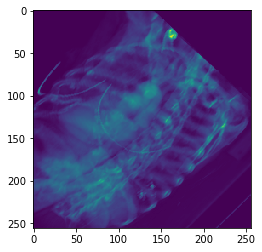

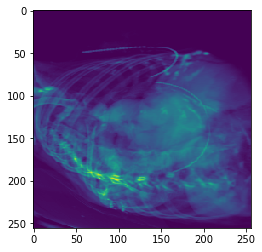

In [4]:
root = 'DRRDatasets'
train_data = DRRDataset(root)
test_data = DRRDataset(root, train=False)



fix, moving, label = train_data[0]

plt.imshow(fix[0])
plt.figure()
plt.imshow(moving[0])
print(label)

In [5]:
fix.shape

torch.Size([1, 256, 256])

# 装入dataloader

In [6]:
batch=16
num_workers=10

train_loader = DataLoader(train_data,
                        batch_size = batch,
                        shuffle = True,
                        num_workers = num_workers)

test_loader = DataLoader(test_data,
                        batch_size = batch,
                        shuffle = True,
                        num_workers = num_workers)
len(train_loader)

6400

# 定义网络

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG
import torch.nn.functional as F
from torch.nn import init
import numpy as np


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            vgg16 = models.vgg16(pretrained=False)
            vgg16.load_state_dict(torch.load('mnt/vgg16-397923af.pth'))

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:             # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d" % (idx+1)] = x
        return output
    
    
def make_layers(cfg, batch_norm=False):
    """
    :param cfg: cfg['vgg16']
    :param batch_norm:
    :return: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']  数字表示卷积  'M': 表示池化
    """
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

In [9]:
vgg_model = VGGNet()

In [17]:
class RegNet(nn.Module):
    def __init__(self, pretrained_net):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(32768 * 2, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, fix, moving):
        output = self.pretrained_net.forward(fix)
        fix_x5 = output['x5']  # size=[n, 512, x.h/32, x.w/32]
        
        output = self.pretrained_net.forward(moving)
        moving_x5 = output['x5']  # size=[n, 512, x.h/32, x.w/32]
        
#         print(fix_x5.shape, moving_x5.shape)
        
        fix_x5 = fix_x5.view(fix.shape[0], -1)
        moving_x5 = moving_x5.view(moving.shape[0], -1)
        
#         print(fix_x5.shape, moving_x5.shape)
        
        x = torch.cat([fix_x5, moving_x5], dim=1)
        
#         print(x.shape)
        
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.fc4(x)
        
        
#         print(x.shape)
#         score = self.relu(self.deconv1(x5))                  # size=[n, 512, x.h/16, x.w/16]
#         score = self.bn1(score + x4)                         # element-wise add, size=[n, 512, x.h/16, x.w/16]
#         score = self.bn2(self.relu(self.deconv2(score)))     # size=[n, 256, x.h/8, x.w/8]
#         score = self.bn3(self.relu(self.deconv3(score)))     # size=[n, 128, x.h/4, x.w/4]
#         score = self.bn4(self.relu(self.deconv4(score)))     # size=[n, 64, x.h/2, x.w/2]
#         score = self.bn5(self.relu(self.deconv5(score)))     # size=[n, 32, x.h, x.w]
#         score = self.classifier(score)                       # size=[n, n_class, x.h, x.w]

        return x
    
net = RegNet(pretrained_net=vgg_model)

In [14]:
fix_imgs, moving_imgs, labels = next(iter(train_loader))
fix_imgs.shape, moving_imgs.shape, labels.shape

(torch.Size([2, 1, 256, 256]),
 torch.Size([2, 1, 256, 256]),
 torch.Size([2, 10]))

In [16]:
o = net(fix_imgs, moving_imgs)

In [ ]:
criterion = torch.nn.MSELoss()

In [ ]:
lr = 0.00001
optimizer = optim.Adam(net.parameters(),lr=lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
def train(epoch, net):
    net.train()          # tran mode
    total_loss = 0.
    for batch_idx, (fix_imgs, moving_imgs, labels) in enumerate(train_loader):
        N = fix_imgs.size(0)
        
        fix_imgs = fix_imgs.to(device)
        moving_imgs = moving_imgs.to(device)
        labels = labels.to(device)
        net = net.to(device)
        
        
        out = net(fix_imgs, moving_imgs)       # torch.Size([2, 21, 320, 320])

        # with open('./result.txt', 'r+') as f:
        #     f.write(str(out.detach().numpy()))
        #     f.write("\n")

        loss = criterion(out, labels)
        loss /= N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            # update all arguments
        total_loss += loss.cpu().item()

        # if batch_idx == 2:
        #     break

        if (batch_idx) % 20 == 0:
            print('train epoch [%d/%d], iter[%d/%d], lr %.7f, aver_loss %.5f' % (epoch,
                                                                                 epoch_num, batch_idx,
                                                                                 len(train_loader), lr,
                                                                                 total_loss / (batch_idx + 1)))

        assert total_loss is not np.nan
        assert total_loss is not np.inf

    # model save
    if (epoch) % 20 == 0:
        torch.save(net.state_dict(), 'model%d.pth'%epoch)  # save for 5 epochs
    total_loss /= len(train_loader)
    print('train epoch [%d/%d] average_loss %.5f' % (epoch, epoch_num, total_loss))


In [ ]:
epoch_num = 2

for epoch in range(epoch_num):
    train(epoch, net)